In [1]:
from equiv_net import EquivariantNet, load_checkpoint
from equiv_tester import testForSymmetryRotationInvariance
import torch
import torch.nn as nn
import numpy as np
from equiv_aux_utils import flip, rotate_c, flip_rotate_8, flip_rotate_8_vectors_inv, flip_rotate_8_squares_inv, flip_rotate_8_lines_inv
import matplotlib.pyplot as plt
from TrainUtils import get_data_transformer, getSunDataLoaders
from steerable_utils import SobelKernel

In [44]:
model = EquivariantNet(numBlocks=2, blockSize=12, reduction='sobel', equiv_level='flip_rotation', 
                       pPoolDrop=[0]*4, pOctaveDrop=0, use_bn=True, numPoolings=4, 
                       tag='none', use_reduction_before=False, k_pool_size=1,
                       use_reduction_conv=False, loss_type='cosine', initDepth=3)

In [46]:
inp = torch.rand(1,3,64,64)
out = model(inp)
print(out)
in_rot = rotate_c(inp)
print(model(in_rot))
print(model(flip(inp)))

tensor([[0.0016, 0.0003]], grad_fn=<ViewBackward>)
tensor([[ 0.0003, -0.0016]], grad_fn=<ViewBackward>)
tensor([[-0.0016,  0.0003]], grad_fn=<ViewBackward>)


In [18]:
loss = model.getLoss()

In [19]:
loss

MSELoss()

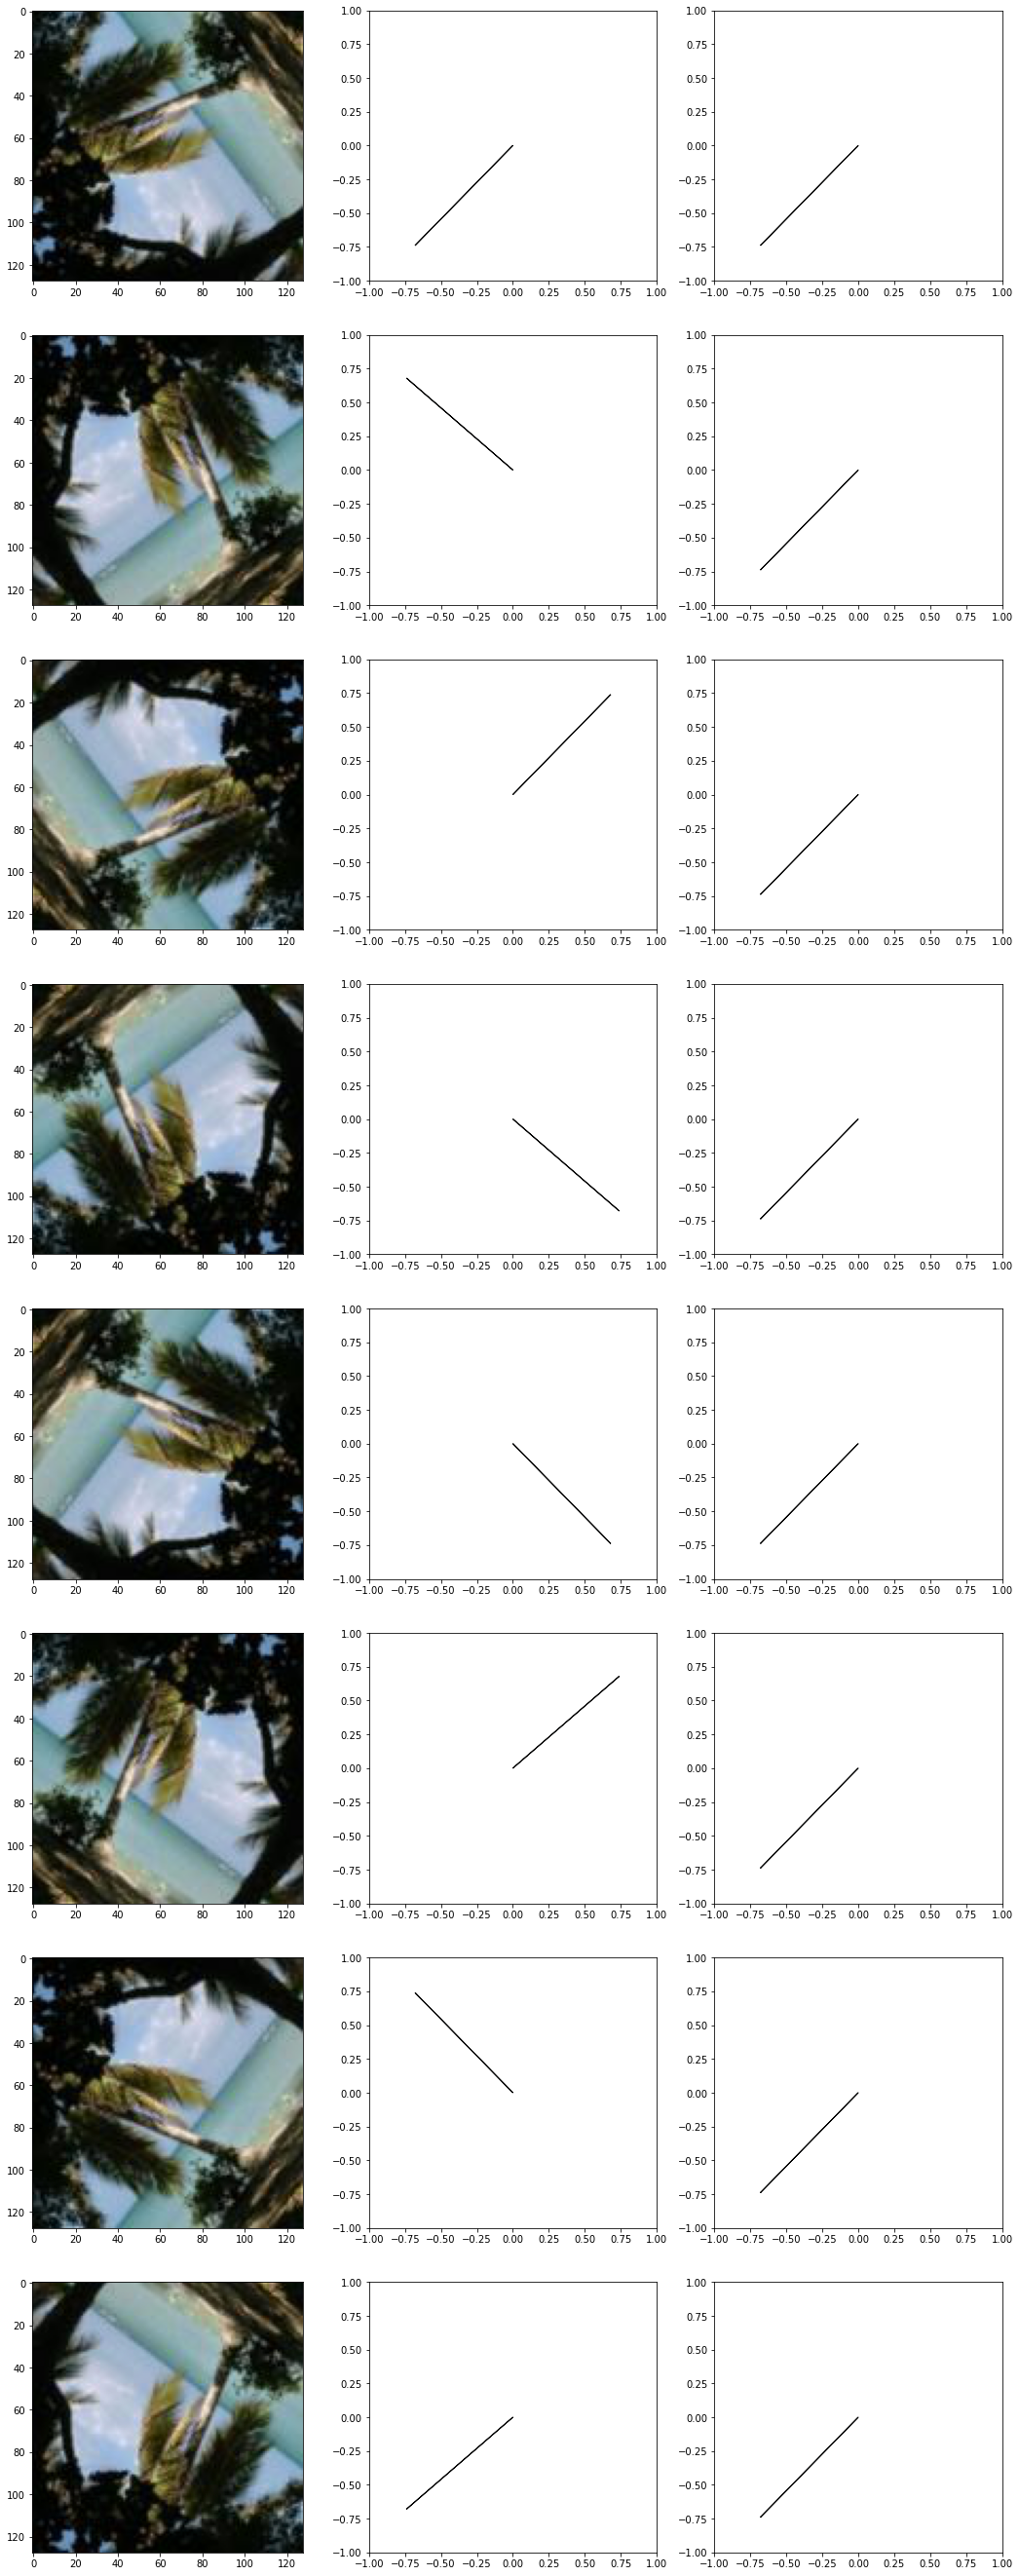

In [11]:
mult = 6
transformer = get_data_transformer([])

im = plt.imread('test_ims/13_127.jpg')
im_tensor = torch.tensor(im.transpose(2,0,1))
aug_real_ims = flip_rotate_8(im_tensor)

im_tr = transformer(im).unsqueeze(0)
augm_ims = flip_rotate_8(im_tr)
fig, axs = plt.subplots(8, 3, figsize = (3*mult,8*mult))
results = []
for i in range(8):
    im_to_infer = augm_ims[i]
    res = model(im_to_infer)
    res_norm = torch.sqrt(res[:, 0]**2 + res[:, 1]**2)
    res = res/res_norm.unsqueeze(-1)
    results.append(res)
    axs[i,0].imshow(aug_real_ims[i].numpy().transpose(1,2,0))
    axs[i,1].arrow(0, 0, res[0,0].item(), res[0,1].item())
    axs[i,1].set_xlim(-1,1)
    axs[i,1].set_ylim(-1,1)
results_derotated = flip_rotate_8_vectors_inv(results)
for i in range(8):
    res = results_derotated[i]
    axs[i,2].arrow(0, 0, res[0,0].item(), res[0,1].item())
    axs[i,2].set_xlim(-1,1)
    axs[i,2].set_ylim(-1,1)

In [ ]:
nn.MSELoss()

In [13]:
model = EquivariantNet(numBlocks=2, blockSize=32, equiv_level='none', pPoolDrop=[0, 0, 0, 0, 0], pOctaveDrop=0, use_bn=True, numPoolings=5, numClasses=2, tag='usual')
model.eval()
print(model.numTrainableParams())

159358


In [20]:
model = EquivariantNet(numBlocks=2, blockSize=12, equiv_level='flip_rotation', pPoolDrop=[0, 0, 0, 0, 0], pOctaveDrop=0, use_bn=True, numPoolings=5, numClasses=2, tag='sobel')
model.eval()
print(model.numTrainableParams())

171518


In [7]:
torch.acos(torch.tensor(1.1))

tensor(nan)

In [36]:
for block_size in [32, 40, 45, 51, 57]:
    model = EquivariantNet(numBlocks=2, blockSize=block_size, equiv_level='none', pPoolDrop=[0]*5, pOctaveDrop=0, use_bn=True, numPoolings=5, numClasses=2)
    model.eval()
    print(block_size, model.numParams())

32 152968
40 237608
45 299933
51 384293
57 479093


In [21]:
for block_size in [12, 14, 16, 18, 20]:
    model = EquivariantNet(numBlocks=2, blockSize=block_size, equiv_level='flip_rotation', pPoolDrop=[0]*5, pOctaveDrop=0, use_bn=True, numPoolings=5, numClasses=2, tag='sobel')
    model.eval()
    print(block_size, model.numParams())

12 171518
14 232582
16 302926
18 382550
20 471454


In [25]:
for block_size in [11, 40, 45, 51, 57]:
    model = EquivariantNet(numBlocks=2, blockSize=block_size, equiv_level='none', pPoolDrop=[0]*3, pOctaveDrop=0, use_bn=True, numPoolings=3, numClasses=2, initDepth=1)
    model.eval()
    print(block_size, model.numParams())

11 9805
40 122644
45 154849
51 198445
57 247441


In [2]:
for block_size in [4, 14, 16, 18, 20]:
    model = EquivariantNet(numBlocks=2, blockSize=block_size, equiv_level='flip_rotation', pPoolDrop=[0]*3, pOctaveDrop=0, use_bn=True, numPoolings=3, numClasses=2, tag='square_4', initDepth=1)
    model.eval()
    print(block_size, model.numParams())

NameError: name 'EquivariantNet' is not defined

In [1]:
from TrainUtils import trainNetworks
#constants and net definition
datasets = ["Lines_fixed_10"]
trainBatchSize, testBatchSize  = 64, 64

learning_rate, lr_decay = 0.1, 0.98
numEpochs = 1

dataAugmentations = [['flip_rotate']]

alpha_changing, min_alpha, max_alpha = False, 1, 3

save_folder='.' 
save_freq=1

netNames = ["EquivariantNet(numBlocks=2, blockSize=5, equiv_level='flip_rotation', pPoolDrop=[0,0], pOctaveDrop=0, use_bn=True, numPoolings=2, tag = 'line_4')"]
#netNames = ["QuadSpatialTransformerNet(2, 8, 2, 8)"]
#netNames = []
#for reduction in ["average", "max", "square"]:
#    netNames.append("QuadNetImproved(2, 8, pPoolDrop = [0,0,0], pOctaveDrop = 0, reduction = '" + 
#                   reduction + "')")

trainNetworks(datasets, trainBatchSize, testBatchSize, dataAugmentations, netNames, 
              learning_rate, lr_decay, numEpochs, 
              alpha_changing, min_alpha, max_alpha,
             testRotation = True, testAddition = False, 
              save_folder=save_folder, save_freq=save_freq,
              test_flipped=False, test_8=[True])

training  EquivariantNet(numBlocks=2, blockSize=5, equiv_level='flip_rotation', pPoolDrop=[0,0], pOctaveDrop=0, use_bn=True, numPoolings=2, tag = 'line_4')
dataset:  Lines_fixed_10
augmentation:  ['flip_rotate']
Model name:  1290812e-c693-4319-84b5-3011ced3c6b3
EquivariantNet(numBlocks=2, blockSize=5, equiv_level='flip_rotation', pPoolDrop=[0,0], pOctaveDrop=0, use_bn=True, numPoolings=2, tag = 'line_4', initDepth = 1, numClasses = 2) will be trained!
Number of parameters:  9688
Number of trainable parameters:  9688
Number of epochs:  1
[1] loss: 0.463 LR: 0.09800 Epoch time: 0.55 s, Remaining time: 0.00 s alpha: 10.00
Loss and avg angle on the train set: 0.41538, 79.63 deg
Loss and avg angle on the test set: 0.49471, 89.48 deg
8 averaging: 
Loss and avg angle on the train set: 0.41538, 79.63 deg
Loss and avg angle on the test set: 0.49471, 89.48 deg
checkpoint saved at  ./1290812e-c693-4319-84b5-3011ced3c6b3.pth
Finished Training
Loss and avg angle on the train set: 0.41538, 79.63 deg

In [4]:
[1]*2 + [2]*0

[1, 1]

In [7]:
model = EquivariantNet(numBlocks=2, blockSize=4, equiv_level='flip_rotation', pPoolDrop=[0, 0], 
                       pOctaveDrop=0, use_bn=True, numPoolings=2, numClasses=2, tag='diagonal')
model.eval()
y = model(torch.rand(6,3,20,20))
print(y.shape)
testForSymmetryRotationInvariance(model, (3,32,32), 2)

torch.Size([6, 2])
[[-0.01599935 -0.00179714]]
[[0.01599934 0.00179713]]
[[-0.01599934 -0.00179711]]
[[0.01599934 0.00179713]]
[[-0.01599936  0.00179712]]
[[ 0.01599934 -0.00179713]]
[[-0.01599935  0.00179713]]
[[ 0.01599935 -0.00179711]]
Not flip invariant
Not rotationally invariant


(False, False)

In [6]:
y = model(torch.rand(1,3,20,20))

After last pool:  torch.Size([1, 504, 10, 10])


In [7]:
y.shape

torch.Size([1, 2])

In [ ]:
4

In [3]:
from steerable_utils import SymmetricalKernel, SobelKernel, DiagonalKernel, SquareKernel

In [9]:
kernel = SquareKernel(2)()

In [10]:
kernel.shape

torch.Size([2, 2, 3, 3])

In [12]:
kernel.dtype

torch.float32

In [6]:
kernel = SteerableKernel(10, 8, 1, 1, 1, 1)()

In [10]:
import torch

In [13]:
torch.stack((torch.rand(3,4), torch.rand(3,4)), dim=2).shape

torch.Size([3, 4, 2])

In [2]:
k_s = SymmetricalKernel(4)

In [9]:
k_s().shape

torch.Size([1, 4, 3, 3])

In [2]:
from TrainUtils import getSquaresDataLoaders

In [3]:
t1,t2,t3,t4, _ = getSquaresDataLoaders(4, 4, [], "fixed_100")

In [4]:
for d in t1:
    break

In [6]:
d[0].shape

torch.Size([4, 1, 64, 64])

In [2]:
k_d = SobelKernel(4)

In [2]:
k_d = DiagonalKernel(4)

In [4]:
k_d()

tensor([[[[ 0.0000, -1.5088,  0.0000],
          [ 1.5088,  0.0000,  1.5088],
          [ 0.0000, -1.5088,  0.0000]],

         [[ 0.0000, -0.5006,  0.0000],
          [ 0.5006,  0.0000,  0.5006],
          [ 0.0000, -0.5006,  0.0000]],

         [[ 0.0000,  1.7156,  0.0000],
          [-1.7156,  0.0000, -1.7156],
          [ 0.0000,  1.7156,  0.0000]],

         [[ 0.0000,  1.3633,  0.0000],
          [-1.3633,  0.0000, -1.3633],
          [ 0.0000,  1.3633,  0.0000]]],


        [[[-0.3791,  0.0000,  0.3791],
          [ 0.0000,  0.0000, -0.0000],
          [ 0.3791,  0.0000, -0.3791]],

         [[-0.7254,  0.0000,  0.7254],
          [ 0.0000,  0.0000, -0.0000],
          [ 0.7254,  0.0000, -0.7254]],

         [[-0.9053,  0.0000,  0.9053],
          [ 0.0000,  0.0000, -0.0000],
          [ 0.9053,  0.0000, -0.9053]],

         [[-0.5120,  0.0000,  0.5120],
          [ 0.0000,  0.0000, -0.0000],
          [ 0.5120,  0.0000, -0.5120]]]], grad_fn=<CatBackward>)

In [44]:
np.random.randint(0, 2, (10))

array([1, 1, 1, 0, 0, 1, 0, 0, 1, 1])

In [45]:
torch.randint(0, 2, (10,))

tensor([1, 0, 0, 1, 0, 0, 1, 1, 0, 1])

In [46]:
x = torch.rand(1,3,4,5)

In [47]:
x[:] = 0

In [2]:
from equiv_utils import OctaveDrop

In [10]:
x = torch.rand(4,6)
print(x)

tensor([[6.2438e-01, 3.3705e-01, 7.0384e-01, 8.0217e-01, 5.0336e-01, 9.0112e-02],
        [2.0252e-01, 2.5485e-02, 4.7947e-02, 6.9292e-01, 1.2646e-01, 2.7601e-01],
        [1.9319e-01, 1.5440e-01, 7.2801e-01, 8.7302e-01, 6.1475e-01, 9.5963e-05],
        [1.6311e-01, 9.3908e-01, 4.2395e-01, 1.0379e-02, 9.9637e-01, 7.2449e-02]])


In [14]:
print(OctaveDrop(0.5, 2)(x))

tensor([[1.2488, 0.6741, 1.4077, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.3858, 0.2529, 0.5520],
        [0.3864, 0.3088, 1.4560, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0208, 1.9927, 0.1449]])


In [21]:
x = uuid4()

In [22]:
str(x)

'e536c17e-0977-4fa7-ab35-2032b032faf3'

In [16]:
torch.nn.functional.conv2d(torch.rand(1,3,32,32), torch.rand(4,3,3,3), bias=torch.rand(4), padding=1).shape

torch.Size([1, 4, 32, 32])

In [1]:
from TrainUtils import trainNetworks
#constants and net definition
dataset = "Cifar-100"
trainBatchSize, testBatchSize  = 128, 128

learning_rate, lr_decay = 0.01, 0.98
numEpochs = 1

dataAugmentation = False

alpha_changing, min_alpha, max_alpha = False, 1, 3

netNames = ["UsualDenseNet(4, 8)"]
#netNames = ["QuadSpatialTransformerNet(2, 8, 2, 8)"]
#netNames = []
#for reduction in ["average", "max", "square"]:
#    netNames.append("QuadNetImproved(2, 8, pPoolDrop = [0,0,0], pOctaveDrop = 0, reduction = '" + 
#                   reduction + "')")

trainNetworks(dataset, trainBatchSize, testBatchSize, dataAugmentation, netNames, 
              learning_rate, lr_decay, numEpochs, 
              alpha_changing, min_alpha, max_alpha,
             testRotation = True, testAddition = False)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
UsualDenseNet(4, 8, initDepth = 3, numClasses = 100) will be trained!
Number of parameters:  50704
Number of trainable parameters:  50704
Number of epochs:  1


KeyboardInterrupt: 

In [6]:
from equiv_aux_utils import flip, rotate_c, rotate_cc

In [2]:
def random_4_rotation(x):
    to_apply = {0: lambda x: x,
                1: rotate_c,
                2: lambda x: rotate_c(rotate_c(x)),
                3: rotate_cc}
    ind = np.random.randint(4)
    return to_apply[ind](x)

In [3]:
def random_8_flip_rotation(x):
    to_apply = {0: lambda x: x,
                1: rotate_c,
                2: lambda x: rotate_c(rotate_c(x)),
                3: rotate_cc,
                4: flip,
                5: lambda x: rotate_c(flip(x)),
                6: lambda x: rotate_c(rotate_c(flip(x))),
                7: lambda x: rotate_cc(flip(x))}
    ind = np.random.randint(8)
    return to_apply[ind](x)

In [28]:
np.random.rand(3,4,5).transpose(-2,-1)

ValueError: axes don't match array

In [29]:
torch.rand(3,4,5).numpy()

array([[[0.41817904, 0.43854278, 0.42170697, 0.05799109, 0.49680954],
        [0.23455393, 0.60450804, 0.43032378, 0.59303975, 0.58440155],
        [0.06517982, 0.58154476, 0.94727814, 0.5121029 , 0.41891962],
        [0.5864869 , 0.8985517 , 0.6773052 , 0.7365393 , 0.9481863 ]],

       [[0.9363136 , 0.08621705, 0.9688459 , 0.62474877, 0.9021197 ],
        [0.3617952 , 0.61431897, 0.16438639, 0.78828794, 0.6625746 ],
        [0.57330686, 0.10849148, 0.6830342 , 0.91433287, 0.13357419],
        [0.47105414, 0.7081156 , 0.6766909 , 0.33593774, 0.40336096]],

       [[0.36479217, 0.37975705, 0.4685079 , 0.1694637 , 0.53155786],
        [0.3400874 , 0.57018775, 0.90499777, 0.7787994 , 0.6117567 ],
        [0.19741821, 0.07011366, 0.12967026, 0.01208204, 0.7769522 ],
        [0.9788004 , 0.42518198, 0.848774  , 0.56962794, 0.5734695 ]]],
      dtype=float32)

In [21]:
x = torch.rand(4,5,6)
print(x)

tensor([[[0.5787, 0.0815, 0.9495, 0.9300, 0.7811, 0.0367],
         [0.1348, 0.6038, 0.0264, 0.6643, 0.7920, 0.7357],
         [0.4799, 0.2604, 0.0239, 0.4551, 0.7021, 0.9801],
         [0.3938, 0.5524, 0.9963, 0.6297, 0.0964, 0.2545],
         [0.5262, 0.1769, 0.3064, 0.6739, 0.9259, 0.7824]],

        [[0.9767, 0.9639, 0.6050, 0.7459, 0.2334, 0.4011],
         [0.8038, 0.0056, 0.8845, 0.5630, 0.5020, 0.1656],
         [0.8263, 0.5356, 0.4742, 0.9915, 0.1257, 0.9568],
         [0.1913, 0.2157, 0.4989, 0.2157, 0.9963, 0.2729],
         [0.3139, 0.0187, 0.7863, 0.5081, 0.7984, 0.8642]],

        [[0.9842, 0.4367, 0.8583, 0.5681, 0.1331, 0.2237],
         [0.2416, 0.2880, 0.6434, 0.9661, 0.4786, 0.4896],
         [0.1358, 0.1173, 0.7918, 0.5360, 0.6625, 0.8251],
         [0.2063, 0.7241, 0.5788, 0.2763, 0.4608, 0.3676],
         [0.9462, 0.9557, 0.0352, 0.0737, 0.1630, 0.5265]],

        [[0.5400, 0.8322, 0.4605, 0.0144, 0.2857, 0.6305],
         [0.7132, 0.7374, 0.0574, 0.7883, 0.5813, 

In [25]:
random_8_flip_rotation(x)

tensor([[[0.0367, 0.7811, 0.9300, 0.9495, 0.0815, 0.5787],
         [0.7357, 0.7920, 0.6643, 0.0264, 0.6038, 0.1348],
         [0.9801, 0.7021, 0.4551, 0.0239, 0.2604, 0.4799],
         [0.2545, 0.0964, 0.6297, 0.9963, 0.5524, 0.3938],
         [0.7824, 0.9259, 0.6739, 0.3064, 0.1769, 0.5262]],

        [[0.4011, 0.2334, 0.7459, 0.6050, 0.9639, 0.9767],
         [0.1656, 0.5020, 0.5630, 0.8845, 0.0056, 0.8038],
         [0.9568, 0.1257, 0.9915, 0.4742, 0.5356, 0.8263],
         [0.2729, 0.9963, 0.2157, 0.4989, 0.2157, 0.1913],
         [0.8642, 0.7984, 0.5081, 0.7863, 0.0187, 0.3139]],

        [[0.2237, 0.1331, 0.5681, 0.8583, 0.4367, 0.9842],
         [0.4896, 0.4786, 0.9661, 0.6434, 0.2880, 0.2416],
         [0.8251, 0.6625, 0.5360, 0.7918, 0.1173, 0.1358],
         [0.3676, 0.4608, 0.2763, 0.5788, 0.7241, 0.2063],
         [0.5265, 0.1630, 0.0737, 0.0352, 0.9557, 0.9462]],

        [[0.6305, 0.2857, 0.0144, 0.4605, 0.8322, 0.5400],
         [0.9075, 0.5813, 0.7883, 0.0574, 0.7374, 

In [1]:
from TrainUtils import getPlanesDataLoaders

In [2]:
train_loader, train_test_loader, test_loader, classes, shape = getPlanesDataLoaders(4, 4, [])

In [3]:
for data in train_loader:
    inputs, labels = data
    break

In [6]:
labels

tensor([0, 0, 0, 1])

In [1]:
import torch

In [2]:
from equiv_aux_utils import flip_rotate_8

[tensor([[[[0.2664, 0.7559, 0.9903, 0.2471, 0.3033],
           [0.7759, 0.2851, 0.5179, 0.5046, 0.4968],
           [0.6447, 0.4931, 0.2191, 0.9237, 0.0461],
           [0.5532, 0.5591, 0.9346, 0.5410, 0.5986]],
 
          [[0.4543, 0.2971, 0.0052, 0.7581, 0.0556],
           [0.4127, 0.1218, 0.4084, 0.2239, 0.4892],
           [0.9960, 0.5698, 0.1523, 0.4302, 0.3320],
           [0.6015, 0.9709, 0.3508, 0.9128, 0.5807]],
 
          [[0.6938, 0.1831, 0.2138, 0.7108, 0.2983],
           [0.4612, 0.7341, 0.3735, 0.4622, 0.8552],
           [0.2533, 0.5371, 0.7700, 0.1294, 0.4539],
           [0.8741, 0.9155, 0.8972, 0.8046, 0.8139]]]]),
 tensor([[[[0.5532, 0.6447, 0.7759, 0.2664],
           [0.5591, 0.4931, 0.2851, 0.7559],
           [0.9346, 0.2191, 0.5179, 0.9903],
           [0.5410, 0.9237, 0.5046, 0.2471],
           [0.5986, 0.0461, 0.4968, 0.3033]],
 
          [[0.6015, 0.9960, 0.4127, 0.4543],
           [0.9709, 0.5698, 0.1218, 0.2971],
           [0.3508, 0.1523, 0.4084, 

In [36]:
x1 = torch.rand(3, 5)
x2 = torch.rand(3, 5)
0.5*(1 - nn.CosineSimilarity()(x1,x2)).mean()

tensor(0.0187)

In [41]:
angle = torch.acos(torch.tensor(-1.0))

In [42]:
angle

tensor(3.1416)

In [43]:
torch.pi

AttributeError: module 'torch' has no attribute 'pi'

In [37]:
x = torch.rand(10, 2)
print(x)

tensor([[0.9608, 0.6001],
        [0.8227, 0.1336],
        [0.9591, 0.0648],
        [0.1625, 0.2705],
        [0.2735, 0.6162],
        [0.9243, 0.3352],
        [0.6436, 0.0644],
        [0.9490, 0.5482],
        [0.4516, 0.7917],
        [0.9727, 0.8797]])


In [41]:
x[...,-1]

tensor([0.6001, 0.1336, 0.0648, 0.2705, 0.6162, 0.3352, 0.0644, 0.5482, 0.7917,
        0.8797])

In [49]:
def rotate_vec_c(x):
    return torch.stack((x[...,1], -x[...,0]), dim=-1)

In [53]:
def rotate_vec_cc(x):
    return torch.stack((-x[...,1], x[...,0]), dim=-1)

In [57]:
def flip_vec(x):
    return torch.stack((-x[...,0], x[...,1]), dim=-1)

In [61]:
def flip_rotate_8_vectors_inv(v):
    res = [v[0],
           rotate_vec_cc(v[1]),
           rotate_vec_c(rotate_vec_c(v[2])),
           rotate_vec_c(v[3]),
           flip_vec(v[4]),
           rotate_vec_cc(flip_vec(v[5])),
           rotate_vec_c(rotate_vec_c(flip_vec(v[6]))),
           rotate_vec_c(flip_vec(v[7]))]
    return res

In [16]:
x = torch.rand(4,4)

In [17]:
x

tensor([[0.3425, 0.8834, 0.7246, 0.9732],
        [0.4768, 0.2952, 0.4255, 0.9941],
        [0.2449, 0.3054, 0.4142, 0.0271],
        [0.8899, 0.1544, 0.4366, 0.7854]])

In [18]:
x.transpose(-1,-2)

tensor([[0.3425, 0.4768, 0.2449, 0.8899],
        [0.8834, 0.2952, 0.3054, 0.1544],
        [0.7246, 0.4255, 0.4142, 0.4366],
        [0.9732, 0.9941, 0.0271, 0.7854]])

In [20]:
x.flip(-1).flip(-2)

tensor([[0.7854, 0.4366, 0.1544, 0.8899],
        [0.0271, 0.4142, 0.3054, 0.2449],
        [0.9941, 0.4255, 0.2952, 0.4768],
        [0.9732, 0.7246, 0.8834, 0.3425]])

In [23]:
x.flip(-2).flip(-1) - rotate_c(rotate_c(x))

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])